# Compulsory Assignment #1 — Machine Learning and Deep Learning (CDSCO2041C)

**Student IDs (fill in):**  
- <ID_1>  
- <ID_2>  
- <ID_3>  

This notebook provides complete, runnable solutions for:

1. **Exploratory Data Analysis (EDA)**  
   1. Covariance & correlation analysis (**implemented from scratch; no built-in cov/corr**).  
   2. Visualisation + brief explanation of patterns.
2. **Cluster analysis** of emission *subsectors* based on emission trajectories over time.
3. **Policy interpretation & critical analysis** (territorial totals vs international aviation/shipping, Paris Agreement coverage, and alignment with long-term targets).

Dataset: `greenhouse-gas-emissions.xlsx` (sheet `UK_by_source`).


In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

DATA_PATH = "greenhouse-gas-emissions.xlsx"  # same folder as notebook when you submit

# Load dataset
uk = pd.read_excel(DATA_PATH, sheet_name="UK_by_source")

# Basic cleaning for consistent string comparisons
for col in [
    "Included in UK territorial total",
    "Included in UK Paris Agreement total",
    "Included in UK UNFCCC total",
]:
    if col in uk.columns:
        uk[col] = uk[col].astype(str).str.strip()

uk.head()

,Included in UK territorial total,GHG,GHG grouped,CRT category,CRT category description,Year,Territory name,Territorial Emissions Statistics sector,Territorial Emissions Statistics subsector,Territorial Emissions Statistics category,Source,Fuel group,Fuel,Activity,Emissions (MtCO2e)
0,No,CH4,CH4,1D1a,International Aviation,1990,United Kingdom,International aviation and shipping,International aviation and shipping,International aviation,Aircraft - international take off and landing,Petroleum,Aviation turbine fuel,Aviation turbine fuel,0.008548
1,No,CH4,CH4,1D1a,International Aviation,1990,United Kingdom,International aviation and shipping,International aviation and shipping,International aviation,Aircraft - international take off and landing,Petroleum,Other petroleum products,Aviation spirit,0.000008
2,No,CH4,CH4,1D1a,International Aviation,1990,United Kingdom,International aviation and shipping,International aviation and shipping,International aviation,Aircraft between UK and Bermuda - TOL,Petroleum,Aviation turbine fuel,Aviation turbine fuel,0.000012
3,No,CH4,CH4,1D1a,International Aviation,1990,United Kingdom,International aviation and shipping,International aviation and shipping,International aviation,Aircraft between UK and CDs - TOL,Petroleum,Aviation turbine fuel,Aviation turbine fuel,0.000735
4,No,CH4,CH4,1D1a,International Aviation,1990,United Kingdom,International aviation and shipping,International aviation and shipping,International aviation,Aircraft between UK and CDs - TOL,Petroleum,Other petroleum products,Aviation spirit,0.000007


## 0. Quick dataset overview

The data is in **long format**, with one row per *(year × geography × sector/subsector/source/fuel/activity/ghg)* and an **emissions value** in MtCO₂e.

We'll mainly use:
- `Year`
- `Emissions (MtCO2e)`
- `Territorial Emissions Statistics sector`
- `Territorial Emissions Statistics subsector`
- `Fuel group`
- Policy indicators:
  - `Included in UK territorial total`
  - `Included in UK Paris Agreement total`


In [ ]:
print("Rows, cols:", uk.shape)
print("Years:", uk["Year"].min(), "→", uk["Year"].max(), "| n =", uk["Year"].nunique())
print("Unique sectors:", uk["Territorial Emissions Statistics sector"].nunique())
print("Unique subsectors:", uk["Territorial Emissions Statistics subsector"].nunique())
print("Unique sources:", uk["Source"].nunique())
print("Unique fuel groups:", uk["Fuel group"].nunique())
print("Missing emissions:", uk["Emissions (MtCO2e)"].isna().sum())

Rows, cols: (78022, 15)

Years: 1990 → 2024 | n = 35

Unique sectors: 9
Unique subsectors: 28
Unique sources: 700
Unique fuel groups: 5

Missing emissions: 0


## 1. Custom covariance & correlation (no built-in functions)

We implement:
- mean
- variance, standard deviation
- covariance
- correlation

Formulas (sample versions, ddof=1):
- **cov(x,y) = Σ (xi−x̄)(yi−ȳ) / (n−1)**
- **corr(x,y) = cov(x,y) / (sx·sy)**


In [3]:
def mean(xs):
    xs = list(xs)
    return sum(xs) / len(xs)

def variance(xs, ddof=1):
    xs = list(xs)
    n = len(xs)
    if n <= ddof:
        return float("nan")
    m = mean(xs)
    return sum((x - m) ** 2 for x in xs) / (n - ddof)

def std(xs, ddof=1):
    v = variance(xs, ddof=ddof)
    return math.sqrt(v) if not math.isnan(v) else float("nan")

def covariance(xs, ys, ddof=1):
    xs, ys = list(xs), list(ys)
    n = len(xs)
    if n != len(ys) or n <= ddof:
        return float("nan")
    mx, my = mean(xs), mean(ys)
    return sum((x - mx) * (y - my) for x, y in zip(xs, ys)) / (n - ddof)

def correlation(xs, ys):
    cov = covariance(xs, ys, ddof=1)
    sx = std(xs, ddof=1)
    sy = std(ys, ddof=1)
    if sx == 0 or sy == 0 or math.isnan(cov) or math.isnan(sx) or math.isnan(sy):
        return float("nan")
    return cov / (sx * sy)

# quick sanity check
x = [1, 2, 3, 4, 5]
y = [2, 4, 6, 8, 10]
print("corr(x,y) should be ~1.0:", correlation(x, y))

corr(x,y) should be ~1.0: 0.9999999999999998


## Question 1.1 — Covariance & correlation analysis across years

### Choice of variables
To keep the analysis interpretable, we start with the **8 top-level territorial sectors**, aggregated to annual totals (**territorial total = Yes**). This gives 35 years × 8 sectors.

We compute:
- Covariance & correlation matrices across sectors (time series).
- Correlation of each sector with **Year** (strength of long-run decline).


In [4]:
SECTOR_COL = "Territorial Emissions Statistics sector"

territorial = uk[uk["Included in UK territorial total"].str.lower() == "yes"].copy()

# sector-year totals
sec_year = (
    territorial
    .groupby(["Year", SECTOR_COL], as_index=False)["Emissions (MtCO2e)"]
    .sum()
)

pivot_sec = (
    sec_year
    .pivot(index="Year", columns=SECTOR_COL, values="Emissions (MtCO2e)")
    .fillna(0.0)
    .sort_index()
)

pivot_sec.head()

Territorial Emissions Statistics sector,Agriculture,Buildings and product uses,Domestic transport,Electricity supply,Fuel supply,Industry,LULUCF,Waste
Year,,,,,,,,
1990,54.988754,109.492561,124.191169,203.990902,77.192227,155.662400,10.266883,55.039201
1991,54.800121,121.292199,122.552535,200.562839,78.080868,156.665141,9.772005,56.836696
1992,54.457877,117.743777,123.850246,188.466186,79.240850,149.650442,8.962862,58.000423
1993,53.561508,121.671071,124.995984,170.963203,78.927561,143.356940,8.401128,59.475666
1994,54.320493,116.627834,125.175291,166.731982,71.448923,145.437790,7.925957,60.982346


In [5]:
# Covariance and correlation matrices (custom implementation)
cols = list(pivot_sec.columns)
cov_mat = pd.DataFrame(index=cols, columns=cols, dtype=float)
corr_mat = pd.DataFrame(index=cols, columns=cols, dtype=float)

for a in cols:
    for b in cols:
        cov_mat.loc[a, b] = covariance(pivot_sec[a].values, pivot_sec[b].values, ddof=1)
        corr_mat.loc[a, b] = correlation(pivot_sec[a].values, pivot_sec[b].values)

display(corr_mat.round(3))

,Agriculture,Buildings and product uses,Domestic transport,Electricity supply,Fuel supply,Industry,LULUCF,Waste
Agriculture,1.000,0.793,0.558,0.728,0.927,0.942,0.867,0.864
Buildings and product uses,0.793,1.000,0.669,0.863,0.843,0.810,0.695,0.883
Domestic transport,0.558,0.669,1.000,0.691,0.521,0.493,0.312,0.615
Electricity supply,0.728,0.863,0.691,1.000,0.816,0.793,0.671,0.804
Fuel supply,0.927,0.843,0.521,0.816,1.000,0.986,0.950,0.940
Industry,0.942,0.810,0.493,0.793,0.986,1.000,0.959,0.922
LULUCF,0.867,0.695,0.312,0.671,0.950,0.959,1.000,0.858
Waste,0.864,0.883,0.615,0.804,0.940,0.922,0.858,1.000


In [6]:
# Correlation with Year (trend strength)
years = pivot_sec.index.values
corr_with_year = pd.Series({c: correlation(years, pivot_sec[c].values) for c in cols}).sort_values()
display(corr_with_year.to_frame("corr(Year, sector_emissions)").round(3))


,"corr(Year, sector_emissions)"
Fuel supply,-0.992
Industry,-0.984
LULUCF,-0.937
Waste,-0.932
Agriculture,-0.927
Electricity supply,-0.863
Buildings and product uses,-0.856
Domestic transport,-0.549


### Additional slice: Fuel group trajectories

Fuel groups are few (typically ~5), which makes correlation patterns easy to interpret.


In [7]:

FUEL_COL = "Fuel group"

fuel_year = (
    territorial
    .groupby(["Year", FUEL_COL], as_index=False)["Emissions (MtCO2e)"]
    .sum()
)

pivot_fuel = (
    fuel_year
    .pivot(index="Year", columns=FUEL_COL, values="Emissions (MtCO2e)")
    .fillna(0.0)
    .sort_index()
)

fuel_cols = list(pivot_fuel.columns)
fuel_corr = pd.DataFrame(index=fuel_cols, columns=fuel_cols, dtype=float)

for a in fuel_cols:
    for b in fuel_cols:
        fuel_corr.loc[a, b] = correlation(pivot_fuel[a].values, pivot_fuel[b].values)

display(pivot_fuel.head())
display(fuel_corr.round(3))

corr_fuel_year = pd.Series({c: correlation(pivot_fuel.index.values, pivot_fuel[c].values) for c in fuel_cols}).sort_values()
display(corr_fuel_year.to_frame("corr(Year, fuel_group_emissions)").round(3))


Fuel group,Coal,Gaseous fuels,Other emissions,Other solid fuels,Petroleum
Year,,,,,
1990,221.201645,148.464106,209.842656,14.814075,196.501615
1991,223.790559,156.244617,209.894152,14.290065,196.343011
1992,209.220581,155.377805,205.279474,14.959005,195.535798
1993,179.702582,170.932214,200.649420,15.055283,195.013564
1994,167.372512,179.496265,197.686335,13.784836,190.310669


,Coal,Gaseous fuels,Other emissions,Other solid fuels,Petroleum
Coal,1.000,0.209,0.847,0.911,0.898
Gaseous fuels,0.209,1.000,0.195,0.178,0.272
Other emissions,0.847,0.195,1.000,0.968,0.949
Other solid fuels,0.911,0.178,0.968,1.000,0.949
Petroleum,0.898,0.272,0.949,0.949,1.000


,"corr(Year, fuel_group_emissions)"
Other emissions,-0.974
Other solid fuels,-0.972
Petroleum,-0.971
Coal,-0.925
Gaseous fuels,-0.289


## Question 1.2 — Visualise findings + explain patterns

We visualise:
- UK territorial total emissions over time
- Sector time series (stacked + line)
- Correlation heatmap (sectors)
- Distribution of year-over-year changes (hist/box)
- Scatterplots for pairs with very high correlation (often driven by shared long-run decline)


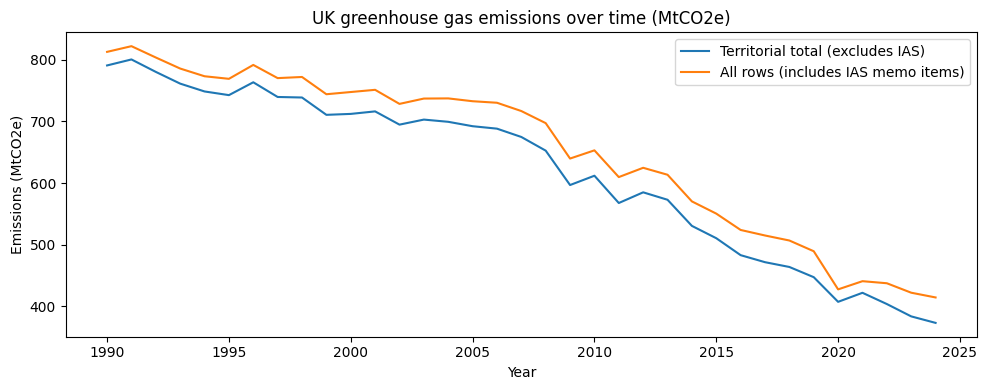

1990 territorial: 790.8240968856052
2024 territorial: 373.40025122418075
Percent change 1990→2024: -52.7833999122318


In [8]:

def total_emissions(df):
    return df.groupby("Year")["Emissions (MtCO2e)"].sum().sort_index()

tot_territorial = total_emissions(territorial)
tot_all = total_emissions(uk)

plt.figure(figsize=(10,4))
plt.plot(tot_territorial.index, tot_territorial.values, label="Territorial total (excludes IAS)")
plt.plot(tot_all.index, tot_all.values, label="All rows (includes IAS memo items)")
plt.title("UK greenhouse gas emissions over time (MtCO2e)")
plt.xlabel("Year")
plt.ylabel("Emissions (MtCO2e)")
plt.legend()
plt.tight_layout()
plt.show()

print("1990 territorial:", float(tot_territorial.loc[1990]))
print("2024 territorial:", float(tot_territorial.loc[2024]))
print("Percent change 1990→2024:",
      (tot_territorial.loc[2024] - tot_territorial.loc[1990]) / tot_territorial.loc[1990] * 100)


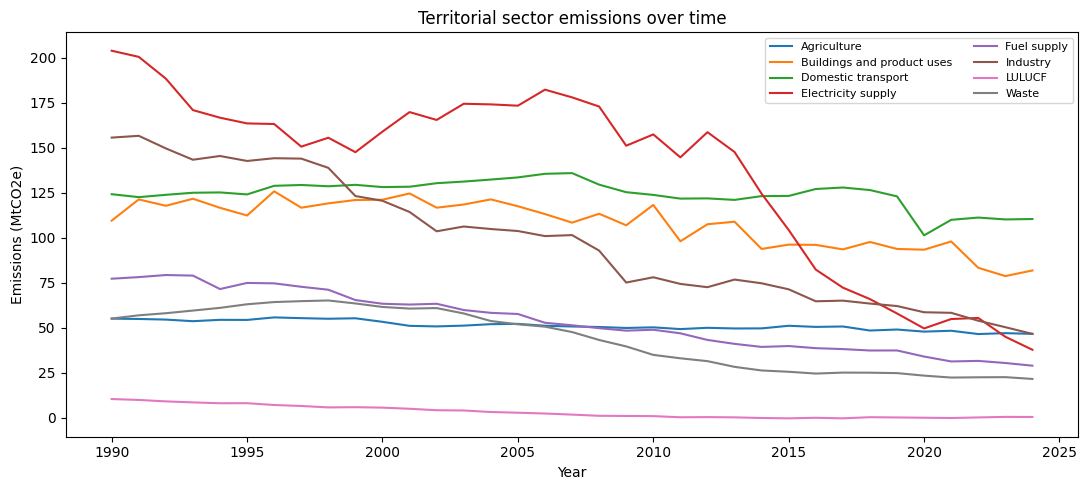

,share in 2024
Territorial Emissions Statistics sector,
Domestic transport,0.296
Buildings and product uses,0.219
Agriculture,0.125
Industry,0.125
Electricity supply,0.101
Fuel supply,0.077
Waste,0.057
LULUCF,0.001


In [9]:

# Sector time series (lines)
plt.figure(figsize=(11,5))
for c in pivot_sec.columns:
    plt.plot(pivot_sec.index, pivot_sec[c], label=c)
plt.title("Territorial sector emissions over time")
plt.xlabel("Year")
plt.ylabel("Emissions (MtCO2e)")
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

# Sector shares in the latest year
latest_year = pivot_sec.index.max()
shares = (pivot_sec.loc[latest_year] / pivot_sec.loc[latest_year].sum()).sort_values(ascending=False)
display(shares.to_frame(f"share in {latest_year}").round(3))


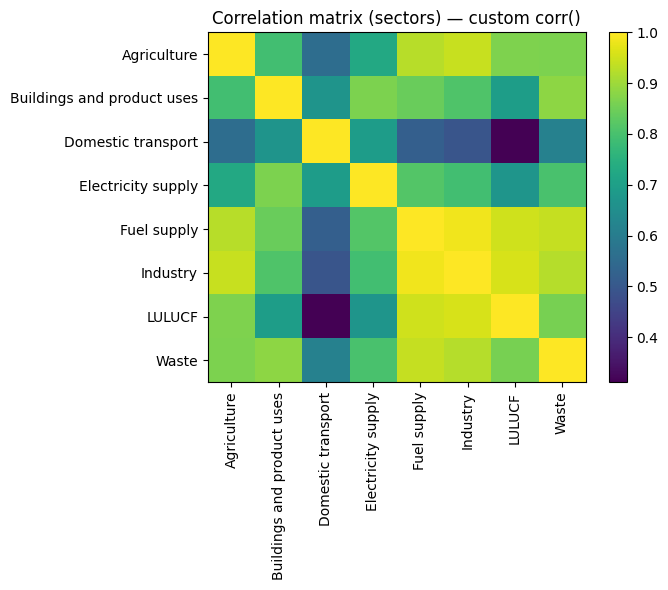

In [10]:

# Correlation heatmap (sectors)
C = corr_mat.values.astype(float)
labels = corr_mat.columns.tolist()

plt.figure(figsize=(7,6))
im = plt.imshow(C, aspect="auto")
plt.colorbar(im)
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.title("Correlation matrix (sectors) — custom corr()")
plt.tight_layout()
plt.show()


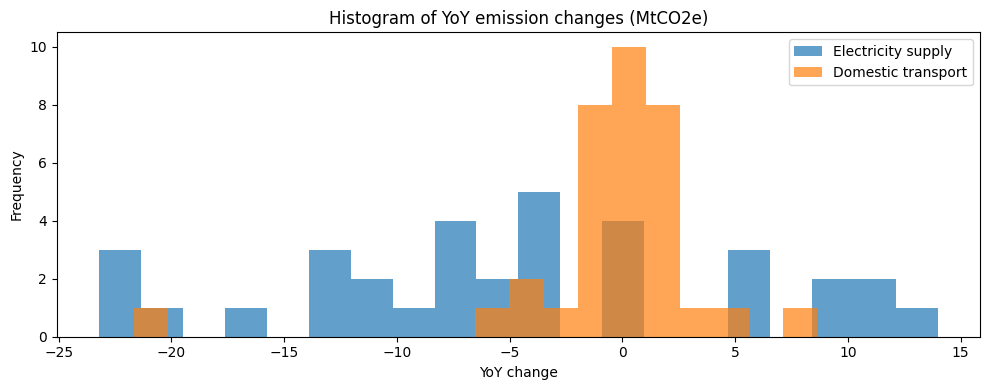

/var/folders/9x/w8_bfdxx2mggfxddhhz5m55r0000gn/T/ipykernel_11094/1094840154.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([yoy[c].values for c in yoy.columns], labels=yoy.columns, vert=True)


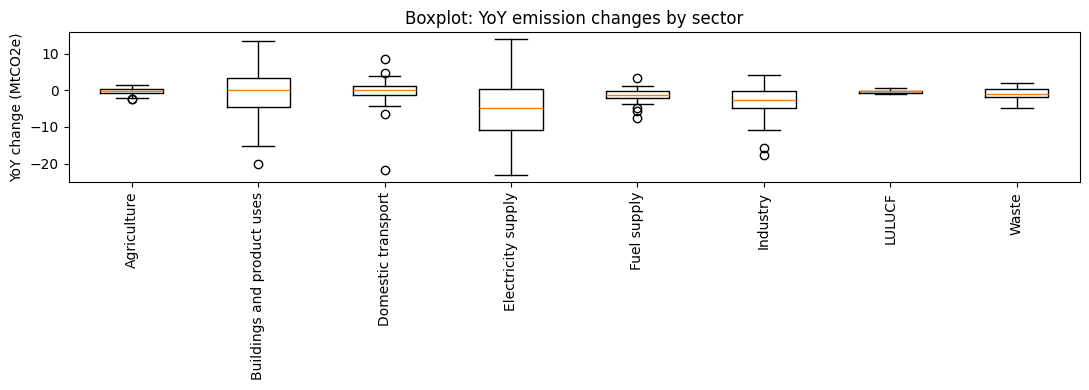

In [11]:

# Year-over-year changes by sector (distribution)
yoy = pivot_sec.diff().dropna()
# Histogram for a couple of sectors
plt.figure(figsize=(10,4))
plt.hist(yoy["Electricity supply"], bins=20, alpha=0.7, label="Electricity supply")
plt.hist(yoy["Domestic transport"], bins=20, alpha=0.7, label="Domestic transport")
plt.title("Histogram of YoY emission changes (MtCO2e)")
plt.xlabel("YoY change")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# Boxplot across all sectors
plt.figure(figsize=(11,4))
plt.boxplot([yoy[c].values for c in yoy.columns], labels=yoy.columns, vert=True)
plt.xticks(rotation=90)
plt.title("Boxplot: YoY emission changes by sector")
plt.ylabel("YoY change (MtCO2e)")
plt.tight_layout()
plt.show()


### Brief interpretation (template you can refine)

Typical findings in this dataset:
- Long-run **declines** in most sectors drive **high positive correlations** between sector time series (they often move down together).
- `Domestic transport` often shows **weaker** correlation with Year than power/industry, reflecting **slower decarbonisation** and periods of plateau.
- Fuel groups show that **coal** tends to fall strongly, while **gaseous fuels** can be flatter (gas replacing coal in some periods), reducing correlation.

Use the plots above to ground your explanation with specific sectors/years.


## Question 2 — Cluster analysis (emission trajectories)

### Algorithm choice
We use **K-Means (implemented from scratch)** to group **subsectors** by similarity in their emission trajectories over time.

### Variables used (justification)
For each subsector we use its **full 1990–2024 annual emission trajectory** (a vector of length 35).  
We standardize each subsector trajectory with a **z-score across years** so clustering reflects *shape* (relative changes) rather than absolute magnitude.

This is appropriate when the goal is to group subsectors that:
- decline fast vs slowly,
- are flat or increasing,
- show volatility vs smooth transitions.


In [12]:

# --- K-Means from scratch (NumPy only) ---
def kmeans(X, k, n_init=20, max_iter=300, tol=1e-6, random_state=42):
    # X: (n_samples, n_features)
    # returns: best_labels, best_centroids, best_inertia
    rng = np.random.default_rng(random_state)
    best_inertia = np.inf
    best_labels = None
    best_centroids = None

    n_samples = X.shape[0]

    for init in range(n_init):
        # random unique initial centroids from samples
        idx = rng.choice(n_samples, size=k, replace=False)
        centroids = X[idx].copy()

        labels = np.zeros(n_samples, dtype=int)

        for it in range(max_iter):
            # assign step
            dists = np.sum((X[:, None, :] - centroids[None, :, :])**2, axis=2)  # squared euclidean
            new_labels = np.argmin(dists, axis=1)

            # update step
            new_centroids = centroids.copy()
            for j in range(k):
                members = X[new_labels == j]
                if len(members) == 0:
                    # re-seed empty cluster
                    new_centroids[j] = X[rng.integers(0, n_samples)]
                else:
                    new_centroids[j] = members.mean(axis=0)

            # check convergence
            shift = np.max(np.abs(new_centroids - centroids))
            centroids = new_centroids
            if np.array_equal(new_labels, labels) or shift < tol:
                labels = new_labels
                break
            labels = new_labels

        # inertia
        inertia = np.sum((X - centroids[labels])**2)
        if inertia < best_inertia:
            best_inertia = inertia
            best_labels = labels.copy()
            best_centroids = centroids.copy()

    return best_labels, best_centroids, best_inertia

SUB_COL = "Territorial Emissions Statistics subsector"

sub_year = (
    territorial
    .groupby(["Year", SUB_COL], as_index=False)["Emissions (MtCO2e)"]
    .sum()
)

pivot_sub = (
    sub_year
    .pivot(index="Year", columns=SUB_COL, values="Emissions (MtCO2e)")
    .fillna(0.0)
    .sort_index()
)

# matrix: subsectors x years
X = pivot_sub.T.values  # (n_subsectors, n_years)

# z-score each subsector across time (shape-based clustering)
Xz = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-9)

k = 4
labels, centroids, inertia = kmeans(Xz, k=k, n_init=50, max_iter=500, random_state=42)

cluster_df = pd.DataFrame({
    "subsector": pivot_sub.columns,
    "cluster": labels
})

# Percent change 1990 -> last year (for interpretation)
y0, y1 = pivot_sub.index.min(), pivot_sub.index.max()
cluster_df["pct_change_1990_{}".format(y1)] = [
    (pivot_sub.loc[y1, s] - pivot_sub.loc[y0, s]) / pivot_sub.loc[y0, s] * 100
    if pivot_sub.loc[y0, s] != 0 else np.nan
    for s in pivot_sub.columns
]

print("Best inertia:", float(inertia))
display(cluster_df.sort_values(["cluster", "subsector"]))


Best inertia: 254.25659473184982


,subsector,cluster,pct_change_1990_2024
1,Agricultural soils,0,-23.633264
4,Commercial buildings,0,7.060207
5,Cropland mineral soils change,0,-17.476340
7,Grassland mineral soils change,0,42.026296
8,Industrial fuel combustion,0,-60.709118
9,Industrial processes,0,-87.786250
10,Livestock,0,-17.543677
11,Oil and gas supply,0,-44.936979
17,Peatland,0,-19.583229
18,Power stations,0,-81.538321


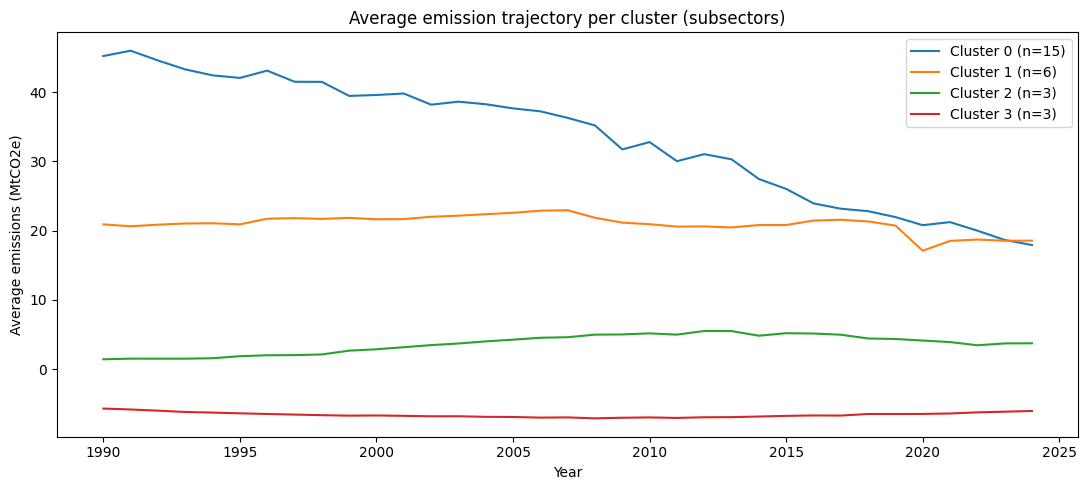

,cluster,top_subsector,emissions_2024
0,0,Residential buildings,54.252837
1,0,Industrial fuel combustion,38.716072
2,0,Power stations,37.660145
3,0,Livestock,29.573440
4,0,Oil and gas supply,27.875109
5,1,Road,99.710861
6,1,Waterborne,3.960009
7,1,Other domestic transport,3.880466
8,1,Railways,1.652352
9,1,Civil aviation,1.182713


In [13]:

# Plot average trajectories per cluster
plt.figure(figsize=(11,5))
for c in sorted(cluster_df["cluster"].unique()):
    members = cluster_df[cluster_df["cluster"] == c]["subsector"].tolist()
    avg = pivot_sub[members].mean(axis=1)
    plt.plot(avg.index, avg.values, label=f"Cluster {c} (n={len(members)})")

plt.title("Average emission trajectory per cluster (subsectors)")
plt.xlabel("Year")
plt.ylabel("Average emissions (MtCO2e)")
plt.legend()
plt.tight_layout()
plt.show()

# Show representative subsectors: biggest absolute emitters in each cluster (latest year)
latest = pivot_sub.index.max()
rows = []
for c in sorted(cluster_df["cluster"].unique()):
    members = cluster_df[cluster_df["cluster"] == c]["subsector"].tolist()
    top = pivot_sub.loc[latest, members].sort_values(ascending=False).head(5)
    for name, val in top.items():
        rows.append((c, name, float(val)))
pd.DataFrame(rows, columns=["cluster", "top_subsector", f"emissions_{latest}"]).sort_values(["cluster", f"emissions_{latest}"], ascending=[True, False])


### Interpretation guide (what to write)

For each cluster, describe:
- whether it **declines quickly**, **declines slowly**, **flat**, or **increasing**;
- which subsectors dominate the cluster (by 2024 emissions);
- plausible explanations (technology change, policy focus, demand patterns, etc.).

Then relate clusters to policy:
- UK Carbon Budgets cover the economy broadly but policy effort is often discussed by sectors such as **power**, **transport**, **buildings (heat)**, **industry**, **agriculture**, **waste**, and **land use (LULUCF)**.
- Clusters dominated by **power stations** or **solid fuel supply** tend to show faster reductions (coal phase-out).
- Clusters dominated by **road transport** or **civil aviation** often show slower reductions and may be more “resistant”.


## Question 3 — Policy interpretation & critical analysis

### 3.1 Territorial totals vs international aviation & shipping (IAS)
Using `Included in UK territorial total`, compare trends:
- **Territorial total (Yes)**: domestic sectors (typical carbon budget accounting).
- **Including IAS memo items**: territorial + international aviation/shipping.

We quantify differences and show a plot.


In [ ]:

# 3.1 Compare trends with vs without IAS
tot_territorial = territorial.groupby("Year")["Emissions (MtCO2e)"].sum().sort_index()
tot_incl_all_rows = uk.groupby("Year")["Emissions (MtCO2e)"].sum().sort_index()

diff = (tot_incl_all_rows - tot_territorial)

out = pd.DataFrame({
    "territorial_total": tot_territorial,
    "all_rows_including_IAS": tot_incl_all_rows,
    "IAS_gap": diff,
    "IAS_gap_pct_of_territorial": diff / tot_territorial * 100
})

display(out.head())
display(out.tail())

plt.figure(figsize=(10,4))
plt.plot(out.index, out["IAS_gap"], label="IAS gap (MtCO2e)")
plt.title("Estimated impact of including IAS memo items")
plt.xlabel("Year")
plt.ylabel("IAS gap (MtCO2e)")
plt.legend()
plt.tight_layout()
plt.show()


### 3.2 Paris Agreement coverage
Using `Included in UK Paris Agreement total`:
- compute totals covered vs not covered,
- list the largest excluded sources/subsectors (latest year).


In [ ]:

pa_yes = uk[uk["Included in UK Paris Agreement total"].str.lower() == "yes"].copy()
pa_no  = uk[uk["Included in UK Paris Agreement total"].str.lower() == "no"].copy()

tot_pa_yes = pa_yes.groupby("Year")["Emissions (MtCO2e)"].sum().sort_index()
tot_pa_all = uk.groupby("Year")["Emissions (MtCO2e)"].sum().sort_index()

pa_gap = tot_pa_all - tot_pa_yes

pa_out = pd.DataFrame({
    "ParisAgreement_included": tot_pa_yes,
    "All_rows": tot_pa_all,
    "Not_included_gap": pa_gap,
    "Not_included_gap_pct": pa_gap / tot_pa_all * 100
})

display(pa_out.tail())

plt.figure(figsize=(10,4))
plt.plot(pa_out.index, pa_out["ParisAgreement_included"], label="Included in Paris Agreement total")
plt.plot(pa_out.index, pa_out["All_rows"], label="All rows")
plt.title("Paris Agreement coverage vs all rows")
plt.xlabel("Year")
plt.ylabel("Emissions (MtCO2e)")
plt.legend()
plt.tight_layout()
plt.show()

# Largest excluded items in latest year (by subsector)
latest = uk["Year"].max()
excl_latest = (
    pa_no[pa_no["Year"] == latest]
    .groupby("Territorial Emissions Statistics subsector")["Emissions (MtCO2e)"]
    .sum()
    .sort_values(ascending=False)
    .head(15)
)
display(excl_latest.to_frame(f"excluded_emissions_{latest}"))


### 3.3 Are historical trends structurally aligned with long-term targets?

We compute:
- overall reduction 1990 → latest year (territorial)
- average annual reduction (linear) and approximate compound annual change rate (CAGR)
- last-10-year reduction rate
- identify “resistant” subsectors using clusters + percent change

Then you can argue: alignment requires not just past decline, but sustained / accelerating reductions in hard-to-abate areas (transport, some industry, agriculture).


In [ ]:

y0, y1 = tot_territorial.index.min(), tot_territorial.index.max()
E0, E1 = float(tot_territorial.loc[y0]), float(tot_territorial.loc[y1])

overall_pct = (E1 - E0) / E0 * 100
years_span = y1 - y0

# simple CAGR (approx)
cagr = (E1 / E0) ** (1/years_span) - 1

# last 10 years
y10 = y1 - 10
E10 = float(tot_territorial.loc[y10])
pct_last10 = (E1 - E10) / E10 * 100
cagr_last10 = (E1 / E10) ** (1/10) - 1

print(f"Territorial emissions {y0}: {E0:.1f} MtCO2e")
print(f"Territorial emissions {y1}: {E1:.1f} MtCO2e")
print(f"Overall change {y0}→{y1}: {overall_pct:.1f}%")
print(f"Approx CAGR {y0}→{y1}: {cagr*100:.2f}%/yr")
print(f"Change last 10y ({y10}→{y1}): {pct_last10:.1f}% | CAGR: {cagr_last10*100:.2f}%/yr")

# Resistant subsectors: smallest reductions or increases
resistant = cluster_df.sort_values("pct_change_1990_{}".format(y1), ascending=False).head(10)
display(resistant)


## Conclusion (what to include in your write-up)

1. **EDA correlation/covariance:**  
   - State which sectors/fuel groups are most strongly linked over time.  
   - Explain why strong correlations can appear due to broad economy-wide decline.

2. **Clusters:**  
   - Label clusters (e.g., *fast-decline power/solid fuels*, *slow-decline transport*, *land-use/removals*, *other/increasing*).  
   - Highlight resistant clusters and what they imply structurally.

3. **Policy interpretation:**  
   - Show that excluding IAS changes the apparent level and sometimes the reduction narrative.  
   - Explain Paris Agreement coverage and what is / isn’t counted.  
   - Use your computed reduction rates to argue whether the pace so far is consistent with long-term goals.

> Replace the interpretation templates above with short, data-backed paragraphs that reference your figures and tables.
